# Credit card fraud detection

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

The dataset that I'm going to use contains transactions made by credit cards in September 2013 by european cardholders.
See [Kaggle dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud).

Due to confidentiality issues, the original features and more background information about the data cannot be provided. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are `Time` and `Amount`. Feature `Time` contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature `Amount` is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature `Class` is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## Imports

For the plots I'm going to use a custom made matplotlibrc style sheet, special thanks to [Jonny Brooks-Bartlett](https://towardsdatascience.com/a-new-plot-theme-for-matplotlib-gadfly-2cffc745ff84)

In [81]:
import matplotlib.pyplot as plt
plt.style.use('gadfly')
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

## Exploratory Data Analysis (EDA)

In [2]:
df = pd.read_csv('./dataset/creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


I want to inspect the summary statistics for each column available.
To achieve this, I define a function (see [link](https://medium.com/swlh/a-complete-guide-to-exploratory-data-analysis-and-data-cleaning-dd282925320f)), that takes my data as an input, and returns a data frame where each feature in my data set is now a row and the summary statistics are columns. The function will take a data frame as an input and calculate summary statistics to reveal insights about the data.

In [4]:
def cols_eda(df): 
    eda_df = {}
    eda_df['null_sum'] = df.isnull().sum()
    eda_df['null_%'] = df.isnull().mean()
    eda_df['dtypes'] = df.dtypes
    eda_df['count'] = df.count()
    eda_df['mean'] = df.mean()
    eda_df['median'] = df.median()
    eda_df['min'] = df.min()
    eda_df['max'] = df.max()
    
    return pd.DataFrame(eda_df)

In [5]:
cols_eda(df)

,count,dtypes,max,mean,median,min,null_%,null_sum
Time,284807,float64,172792.000000,9.481386e+04,84692.000000,0.000000,0.0,0
V1,284807,float64,2.454930,3.919560e-15,0.018109,-56.407510,0.0,0
V2,284807,float64,22.057729,5.688174e-16,0.065486,-72.715728,0.0,0
V3,284807,float64,9.382558,-8.769071e-15,0.179846,-48.325589,0.0,0
V4,284807,float64,16.875344,2.782312e-15,-0.019847,-5.683171,0.0,0
V5,284807,float64,34.801666,-1.552563e-15,-0.054336,-113.743307,0.0,0
V6,284807,float64,73.301626,2.010663e-15,-0.274187,-26.160506,0.0,0
V7,284807,float64,120.589494,-1.694249e-15,0.040103,-43.557242,0.0,0
V8,284807,float64,20.007208,-1.927028e-16,0.022358,-73.216718,0.0,0
V9,284807,float64,15.594995,-3.137024e-15,-0.051429,-13.434066,0.0,0


good news is that there are no missing values and all our variables are numerical.
I will now explore how much the dataset is unbalanced.


Classes distribution 
0    284315
1       492
Name: Class, dtype: int64 
The percentage of fraudulent transaction is 0.17%.
      


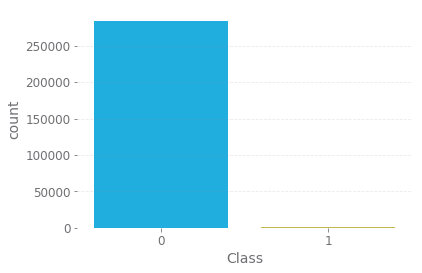

In [6]:
sns.countplot('Class', data=df)

cls_counts = df.Class.value_counts()
print(f"""
Classes distribution \n{cls_counts} \nThe percentage of fraudulent \
transaction is {round(cls_counts[1]*100/cls_counts.sum(),2)}%.
      """)

The dataset is highly imbalanced, most of the transactions are non-fraud.
Therefore, I'm going to build a balanced dataset by random under-sampling the majority class. This will inevitably yield a loss of information.

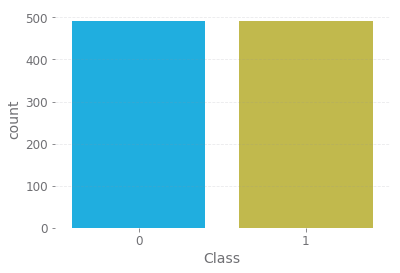

In [7]:
rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_sample(df.drop(columns='Class'), df.Class)
df_balanced  = pd.concat([X,y],axis=1)
sns.countplot('Class', data=df_balanced)

With the balanced dataset we can now investigate the correlations between the various features of the dataset.
In the follwing I'm using `heatmap` from the `seaborn` library, where red and blue denote positive and negative correlation, respectively.
We observe, for example, that while features `V16`, `V17` and `V18` are highly correlated with each other and the other features, features `V19`...`V28` are not.

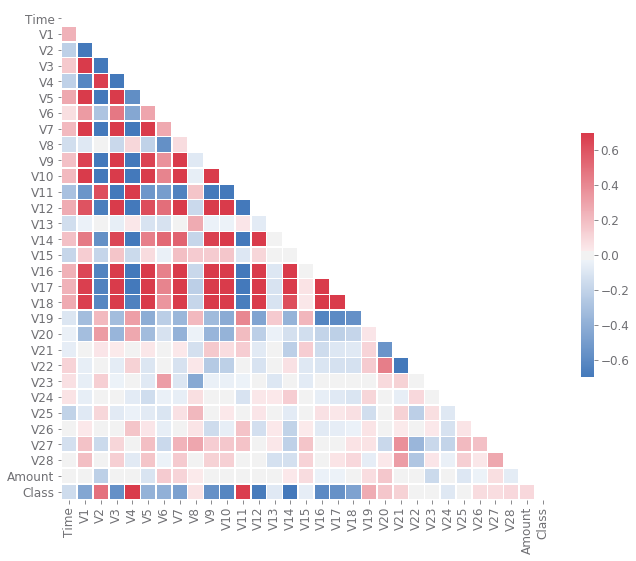

In [8]:
corr = df_balanced.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(250, 9, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-0.7, vmax=0.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

We want to classify wether a certain transaction is fraudulent or not. Therefore, let's take a deeper look at the correlations between the dataset features and the target variable `Class`.

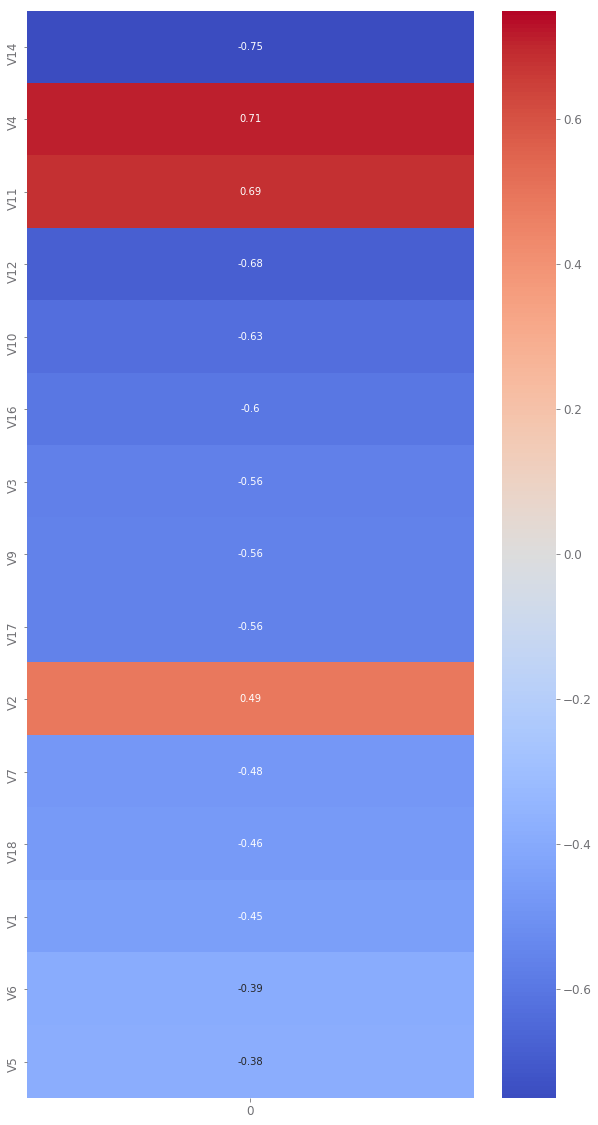

In [9]:
correlations = df_balanced.corrwith(df_balanced['Class']).iloc[:-1].to_frame()
correlations['abs'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('abs', ascending=False)[0]
fig, ax = plt.subplots(figsize=(10,20))
sns.heatmap(sorted_correlations[:15].to_frame(), cmap='coolwarm', annot=True, vmin=-0.75, vmax=0.75, ax=ax);

The results show that features `V14`, `V4`, `V11` and `V12` are the ones with the highest correlation to the `Class` variable, our target.

Let's visualize how the `Class` distribution looks like for these features:

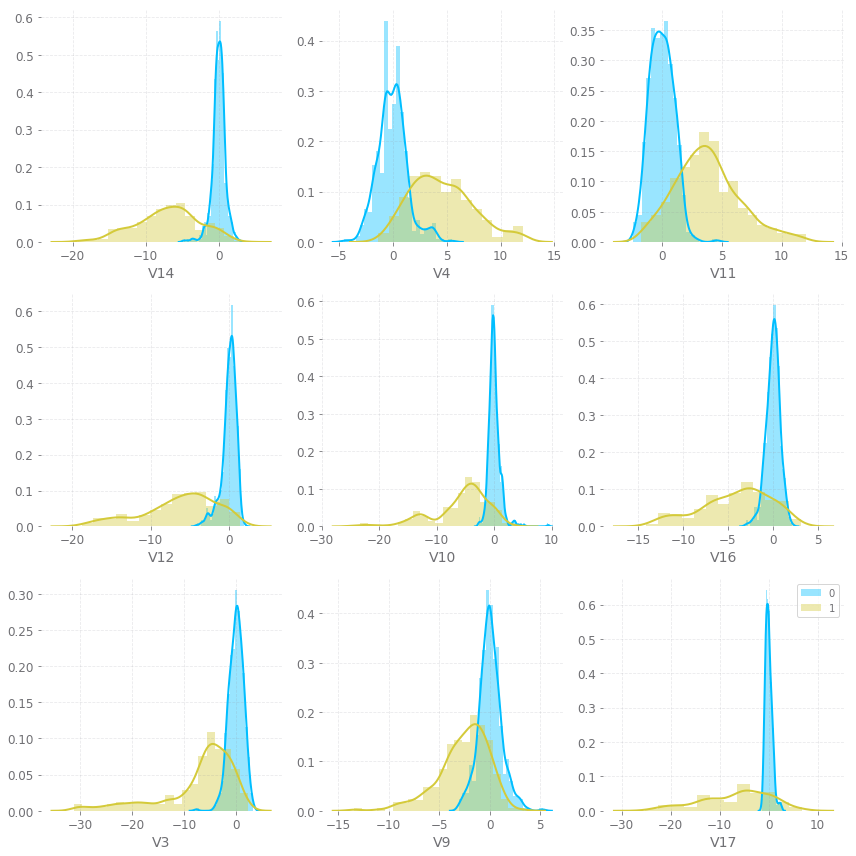

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i, col in enumerate(sorted_correlations.index[:9]):
    sns.distplot(df_balanced[df_balanced.Class==0][col], label='0', ax=axes[i//3][i%3])
    sns.distplot(df_balanced[df_balanced.Class==1][col], label='1', ax=axes[i//3][i%3])
plt.legend()
plt.tight_layout()

For `V14` we observe that more negative values generally indicate that the transaction is fraudulent, whereas for `V4` higher values seem to denote a fraudulent transaction.

# Model training and evaluation

I'm going to split the original dataset in `train` and `test` sets, because I want to keep the reality scenario where fraudulent transactions are very rare while testing my model. I will then randomly undersample the `train` dataset and train the model on it.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Class'), df.Class, test_size=0.2, random_state=42)
X_train_us, y_train_us = rus.fit_sample(X_train, y_train)

In this exercise I don't aim at getting the best model with the best performance, I just want to get good enough results to have a strarting point for discussion.

I'm going to use a logistic regression modell off the shelf using `sklearn` library.

In [14]:
logreg = LogisticRegression()
logreg.fit(X_train_us,y_train_us)
predictions = logreg.predict(X_test)

Given the very strong imbalance of the dataset, using accuracy as a metric is not a useful choice (actually it depends on your goal, discussed later). 
Instead, I'm going to use the confusion matrix that is a very effective, yet simple, classification metric.

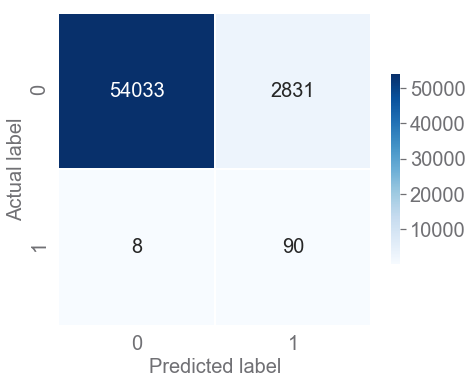

In [87]:
confmat = confusion_matrix(y_test, predictions)
plt.figure(figsize=(7,7))
ax = sns.heatmap(confmat, annot=True, annot_kws={'size':20}, fmt=".0f", 
            linewidths=.5, square = True, cmap = 'Blues', cbar_kws={"shrink": .5})
plt.ylabel('Actual label', size=20)
plt.xlabel('Predicted label', size=20)
plt.tick_params(axis='both', labelsize=20)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)

In [88]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.92      0.06        98

    accuracy                           0.95     56962
   macro avg       0.52      0.93      0.52     56962
weighted avg       1.00      0.95      0.97     56962



Let me give a short explanation of the metrics and results above.
- `accuracy`: total number of correct predictions divided by the total number of predictions,
- `precision`: precision of class tells us how **trustable** is the prediction of the model when it predicts a data point to belong to that class,
- `recall`: recall of a class tells us **how well** the model is able to detect that class,
- `f1-score`: combines precision and recall of a class in one metric.
As we can see the precision of class 1 is very low while recall is very high. Given the high imbalance in our dataset this is to be expected.

There are few points that one should really take into account when dealing with such problems:
- We need to understand our goal, we need to identify and correctly state the problem. In this exercise one should have answered the following questions:
    - What has a bigger impact on our cost function? Would we prefer to catch a fraud while rising false alarms or would we prefer to minimize false alarms (credit card blocked)?
- Resampling methods must be used thoughtfully, knowing that they modify the dataset and therefore the reality.
- Evaluation metrics should be chosen carefully, we need to choose our metrics to get the best overview on how our model performs with regards to our goals.

I recommend the following article [link](https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28). It gives a very exhaustive explanation on how to tackle imbalanced datasets with machine learning.